In this notebook we will:
1. Evaluate bias in the current model  
2. Compute fairness metrics  
3. Identify problematic features  
4. Mitigate bias (e.g. drop or transform features)  
5. Re-train the model  
6. Compare “before vs after” on both performance and fairness  


In [ ]:
import sys
from pathlib import Path

project_root = Path().cwd().parent
sys.path.append(str(project_root))

from src.data_loading.data_loader import load_data, get_numerical_features, get_categorical_features

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
df = load_data()  


Loading data from /Users/nando/Documents/GitHub/Credit_Score_Classification/data/raw/credit_score_dataset.csv
Loaded dataset with 100000 rows and 27 columns


In [ ]:
X = df.drop("Credit_Score", axis=1)
y = df["Credit_Score"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)
print(f"Train set: {X_train.shape[0]} rows, Test set: {X_test.shape[0]} rows")


Train set: 80000 rows, Test set: 20000 rows


## 1- Build & Train Baseline Pipeline

We’ll assemble a minimal `ColumnTransformer` + `RandomForestClassifier`.


In [ ]:
num_feats = get_numerical_features(X_train)
cat_feats = get_categorical_features(X_train)

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),   # fill numeric NaNs
    ("scaler",  StandardScaler()),                   # then scale
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),  
      # fill categorical NaNs with mode
    ("onehot",  OneHotEncoder(handle_unknown="ignore")),  
      # then one-hot encode
])

preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_feats),
    ("cat", cat_pipeline, cat_feats),
])

baseline_pipe = Pipeline([
    ("preproc", preprocessor),
    ("clf",     RandomForestClassifier(random_state=42, n_estimators=100)),
])

baseline_pipe.fit(X_train, y_train)
print("Baseline pipeline trained (with imputation).")


Baseline pipeline trained (with imputation).


## 2- Baseline Evaluation

Compute standard metrics 


=== BASELINE PERFORMANCE ===
              precision    recall  f1-score   support

           0       1.00      0.73      0.84        70
           1       0.97      0.91      0.94      5791
           2       0.93      0.98      0.95     10595
           3       0.98      0.91      0.94      3544

    accuracy                           0.95     20000
   macro avg       0.97      0.88      0.92     20000
weighted avg       0.95      0.95      0.95     20000



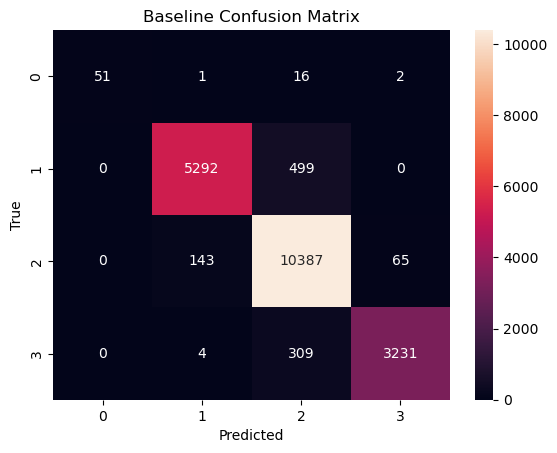

In [ ]:
y_pred_base = baseline_pipe.predict(X_test)

print("=== BASELINE PERFORMANCE ===")
print(classification_report(y_test, y_pred_base))

# Visualize confusion matrix
cm = confusion_matrix(y_test, y_pred_base)
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Baseline Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


## 3- Identify Biased Feature

Check if predictions differ across the sensitive feature **City**.


Predicted distribution by City:


col_0,0,1,2,3
City,,,,
BadShire,0.000000,1.000000,0.000000,0.000000
Lonton,0.000000,0.001250,0.000313,0.998437
Standhampton,0.000000,0.013293,0.980683,0.006023
ZeroVille,0.836066,0.016393,0.114754,0.032787


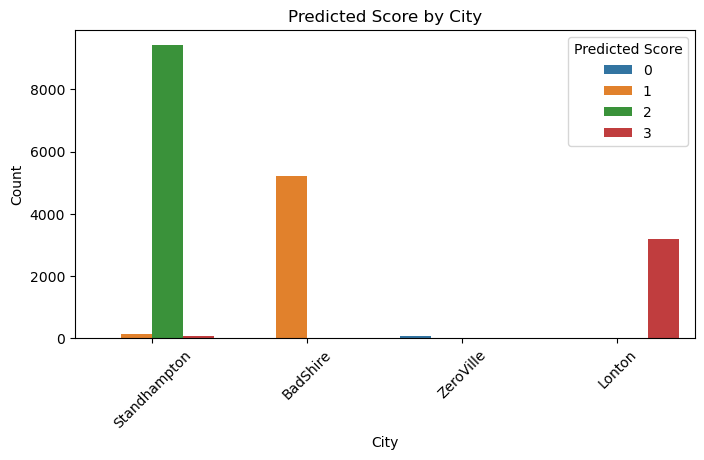

In [ ]:
print("Predicted distribution by City:")
display(pd.crosstab(X_test["City"], y_pred_base, normalize="index"))

# Visualize with countplot
plt.figure(figsize=(8,4))
sns.countplot(x="City", hue=y_pred_base, data=X_test.assign(pred=y_pred_base))
plt.title("Predicted Score by City")
plt.xticks(rotation=45)
plt.xlabel("City")
plt.ylabel("Count")
plt.legend(title="Predicted Score")
plt.show()


## 4- Mitigation: Drop “City”

We’ll remove **City** from features, rebuild & re-train.


In [ ]:
X_train_nb = X_train.drop("City", axis=1)
X_test_nb  = X_test.drop("City", axis=1)

# Recompute feature lists without City
num_feats_nb = get_numerical_features(X_train_nb)
cat_feats_nb = get_categorical_features(X_train_nb)

# Rebuild imputation + transformation pipelines
num_pipeline_nb = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  StandardScaler()),
])
cat_pipeline_nb = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot",  OneHotEncoder(handle_unknown="ignore")),
])

preprocessor_nb = ColumnTransformer([
    ("num", num_pipeline_nb, num_feats_nb),
    ("cat", cat_pipeline_nb, cat_feats_nb),
])

# Assemble mitigated pipeline
mitigated_pipe = Pipeline([
    ("preproc", preprocessor_nb),
    ("clf",     RandomForestClassifier(random_state=42, n_estimators=100)),
])

# Fit mitigated pipeline
mitigated_pipe.fit(X_train_nb, y_train)
print("Mitigated pipeline (no City) trained.")


Mitigated pipeline (no City) trained.


## 5- Post-Mitigation Evaluation

Compare performance & fairness “before vs after”.


=== BASELINE PERFORMANCE ===
              precision    recall  f1-score   support

           0       1.00      0.73      0.84        70
           1       0.97      0.91      0.94      5791
           2       0.93      0.98      0.95     10595
           3       0.98      0.91      0.94      3544

    accuracy                           0.95     20000
   macro avg       0.97      0.88      0.92     20000
weighted avg       0.95      0.95      0.95     20000

=== AFTER DROPPING CITY ===
              precision    recall  f1-score   support

           0       0.89      0.11      0.20        70
           1       0.80      0.81      0.80      5791
           2       0.80      0.83      0.81     10595
           3       0.79      0.71      0.74      3544

    accuracy                           0.80     20000
   macro avg       0.82      0.61      0.64     20000
weighted avg       0.80      0.80      0.80     20000



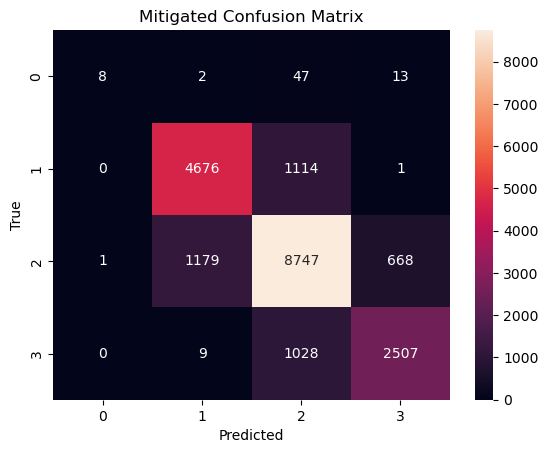

In [8]:
# Cell 11: Predictions after mitigation
y_pred_nb = mitigated_pipe.predict(X_test_nb)

print("=== BASELINE PERFORMANCE ===")
print(classification_report(y_test, y_pred_base))
print("=== AFTER DROPPING CITY ===")
print(classification_report(y_test, y_pred_nb))

# Visualize confusion matrix
cm_nb = confusion_matrix(y_test, y_pred_nb)
sns.heatmap(cm_nb, annot=True, fmt="d")
plt.title("Mitigated Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()



## 6- Summary Comparison

Tabulate & plot accuracy before vs after mitigation.


,Metric,Baseline,No_City
0,Accuracy,0.9480,0.7969
1,F1_macro,0.9206,0.6405


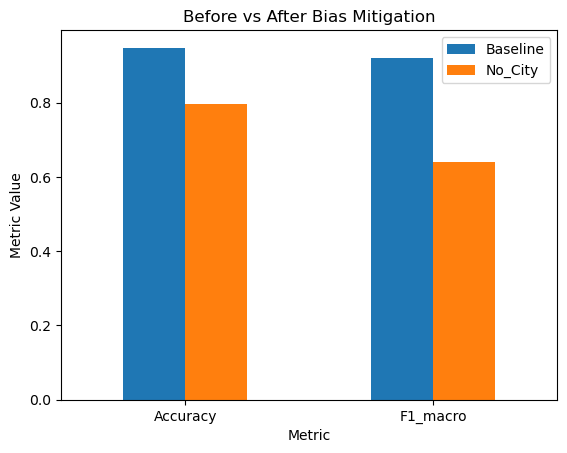

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

# baseline
acc_base = accuracy_score(y_test, y_pred_base)
f1_base  = f1_score     (y_test, y_pred_base, average='macro')

# no-city
acc_nb   = accuracy_score(y_test, y_pred_nb)
f1_nb    = f1_score     (y_test, y_pred_nb, average='macro')

metrics_summary = pd.DataFrame({
    "Metric":    ["Accuracy", "F1_macro"],
    "Baseline":  [np.round(acc_base, 4), np.round(f1_base, 4)],
    "No_City":   [np.round(acc_nb,   4), np.round(f1_nb,   4)]
})
display(metrics_summary)

ax = metrics_summary.set_index("Metric")[["Baseline","No_City"]].plot.bar(rot=0)
ax.set_title("Before vs After Bias Mitigation")
ax.set_ylabel("Metric Value")
plt.show()
